<a href="https://colab.research.google.com/github/Reyad02/PoultryScan/blob/main/Swin_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
!pip install timm
import timm
from timm.loss import LabelSmoothingCrossEntropy
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [ ]:
def get_data_loaders(data_dir, batch_size, train=True):
    if train:
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD),
            T.RandomErasing(p=0.1, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform=transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        transform = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(timm.data.IMAGENET_DEFAULT_MEAN, timm.data.IMAGENET_DEFAULT_STD)
        ])
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return test_loader, len(test_data)


In [ ]:
dataset_path = "/content/drive/MyDrive/Colab Notebooks/DIP/DIP_Splited_Aug_Dataset"
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
test_loader, test_data_len = get_data_loaders(dataset_path, 32, train=False)

classes = get_classes("/content/drive/MyDrive/Colab Notebooks/DIP/DIP_Splited_Aug_Dataset/train")
print(classes, len(classes))


['cocci', 'healthy', 'ncd', 'salmo'] 4


In [ ]:
dataloaders = {
    "train": train_loader
}

dataset_sizes = {
    "train": train_data_len
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True)


Downloading: "https://github.com/SharanSMenon/swin-transformer-hub/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_tiny_patch4_window7_224.pth" to /root/.cache/torch/hub/checkpoints/swin_tiny_patch4_window7_224.pth
100%|██████████| 109M/109M [00:00<00:00, 305MB/s] 


In [ ]:
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)


In [ ]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store training history
    history = {'train_loss': [], 'train_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-" * 10)

        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in tqdm(dataloaders["train"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / dataset_sizes["train"]
        epoch_acc = running_corrects.double() / dataset_sizes["train"]

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print("Train Loss: {:.4f} Acc: {:.4f}".format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Train Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, history



In [ ]:
model_ft, history = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()


Epoch 0/9
----------


100%|██████████| 50/50 [14:25<00:00, 17.30s/it]


Train Loss: 0.5773 Acc: 0.9072

Epoch 1/9
----------


100%|██████████| 50/50 [06:37<00:00,  7.96s/it]


Train Loss: 0.4396 Acc: 0.9764

Epoch 2/9
----------


100%|██████████| 50/50 [06:45<00:00,  8.10s/it]


Train Loss: 0.4177 Acc: 0.9847

Epoch 3/9
----------


100%|██████████| 50/50 [06:39<00:00,  7.99s/it]


Train Loss: 0.4106 Acc: 0.9871

Epoch 4/9
----------


100%|██████████| 50/50 [06:44<00:00,  8.10s/it]


Train Loss: 0.4018 Acc: 0.9913

Epoch 5/9
----------


100%|██████████| 50/50 [06:50<00:00,  8.20s/it]


Train Loss: 0.3964 Acc: 0.9931

Epoch 6/9
----------


100%|██████████| 50/50 [06:50<00:00,  8.21s/it]


Train Loss: 0.3926 Acc: 0.9939

Epoch 7/9
----------


100%|██████████| 50/50 [06:52<00:00,  8.25s/it]


Train Loss: 0.3900 Acc: 0.9951

Epoch 8/9
----------


100%|██████████| 50/50 [06:40<00:00,  8.01s/it]


Train Loss: 0.3882 Acc: 0.9943

Epoch 9/9
----------


100%|██████████| 50/50 [06:44<00:00,  8.09s/it]

Train Loss: 0.3864 Acc: 0.9951

Training complete in 75m 11s
Best Train Acc: 0.9951


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNo

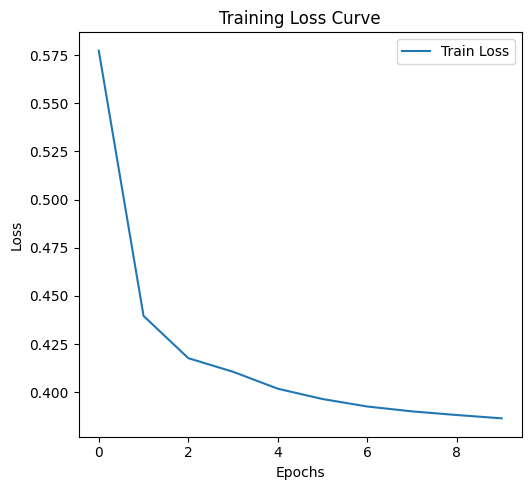

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()




plt.tight_layout()
plt.show()

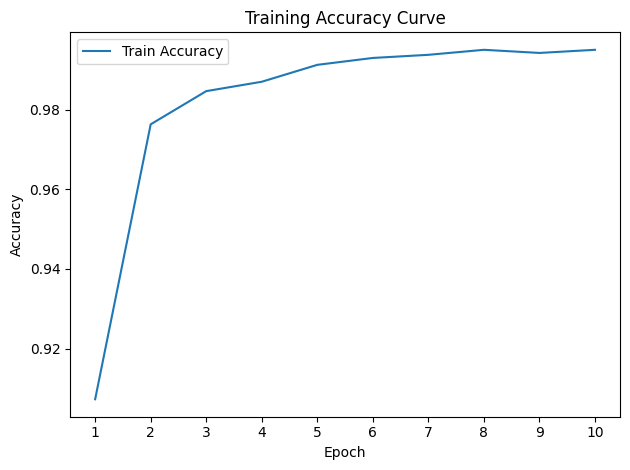

In [ ]:
num_epochs = 10
# Plotting the training accuracy
# plt.figure(figsize=(10, 5))
plt.title("Training Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(range(1, num_epochs + 1), [acc.item() for acc in history['train_acc']], label='Train Accuracy')
plt.xticks(range(1, num_epochs + 1))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/swin_model.pth')


In [ ]:
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
    100 * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)
))


100%|██████████| 50/50 [05:09<00:00,  6.18s/it]

Test Loss: 0.3959
Test Accuracy of cocci: 99% (412/414)
Test Accuracy of healthy: 97% (396/406)
Test Accuracy of   ncd: 99% (297/298)
Test Accuracy of salmo: 98% (445/450)
Test Accuracy of 98% (1550/1568)


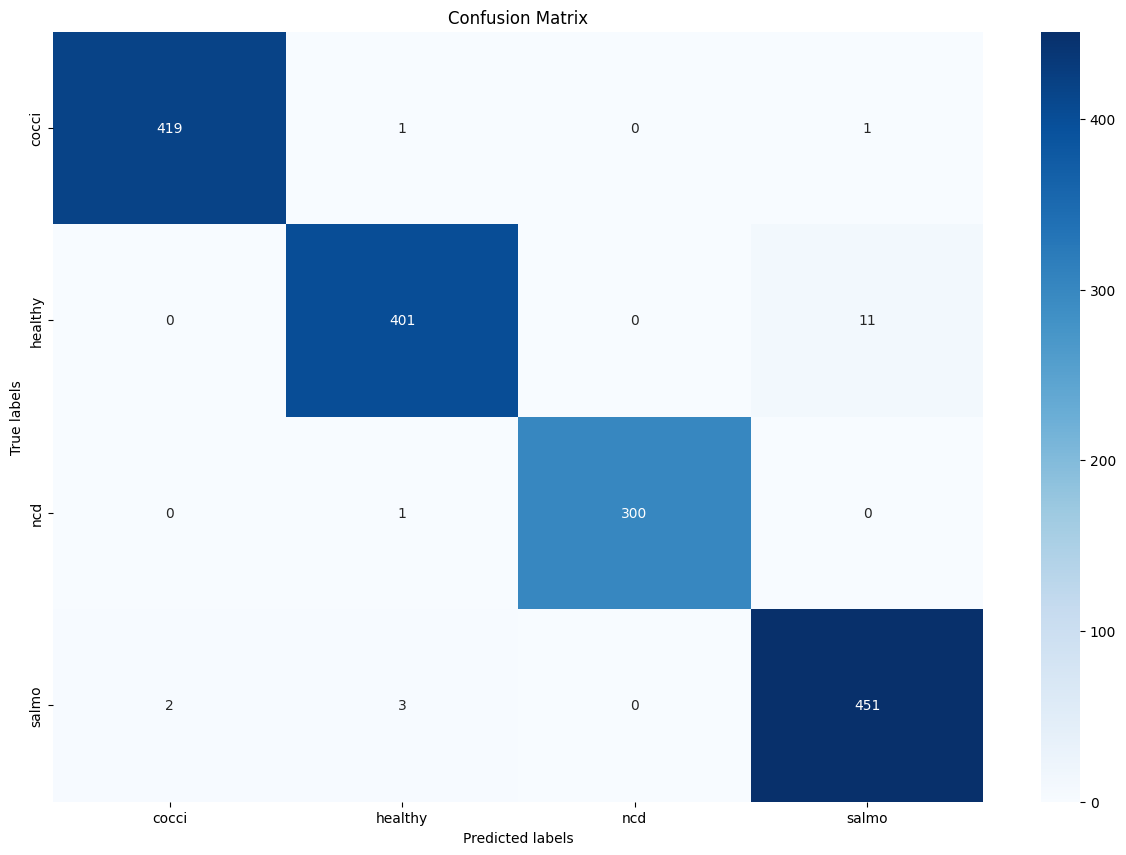

Classification Report:
              precision    recall  f1-score   support

       cocci       1.00      1.00      1.00       421
     healthy       0.99      0.97      0.98       412
         ncd       1.00      1.00      1.00       301
       salmo       0.97      0.99      0.98       456

    accuracy                           0.99      1590
   macro avg       0.99      0.99      0.99      1590
weighted avg       0.99      0.99      0.99      1590

Class: cocci
  Precision: 0.9952
  Recall:    0.9952
  F1 Score:  0.9952
--------------------
Class: healthy
  Precision: 0.9877
  Recall:    0.9733
  F1 Score:  0.9804
--------------------
Class: ncd
  Precision: 1.0000
  Recall:    0.9967
  F1 Score:  0.9983
--------------------
Class: salmo
  Precision: 0.9741
  Recall:    0.9890
  F1 Score:  0.9815
--------------------
Overall Metrics:
  Overall Precision: 0.9881
  Overall Recall:    0.9881
  Overall F1 Score:  0.9881


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

# Set the model to evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    # Append true and predicted labels to lists
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute classification report
class_names = classes  # Your list of class names
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

# Compute precision, recall, and F1 score for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

for i, cls in enumerate(class_names):
    print(f"Class: {cls}")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1 Score:  {f1[i]:.4f}")
    print("-" * 20)

# Compute overall precision, recall, and F1 score
overall_precision = precision_score(true_labels, predicted_labels, average='weighted')
overall_recall = recall_score(true_labels, predicted_labels, average='weighted')
overall_f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Overall Metrics:")
print(f"  Overall Precision: {overall_precision:.4f}")
print(f"  Overall Recall:    {overall_recall:.4f}")
print(f"  Overall F1 Score:  {overall_f1:.4f}")
